In [ ]:
!pip install d2l==0.17.0


     |████████████████████████████████| 83 kB 506 kB/s 


[A Nice Tutorial](https://jalammar.github.io/illustrated-word2vec)

# Pretraining word2vec
We go on to implement the skip-gram
model and pretrain it using negative sampling
on the PTB dataset.

First of all,
let us obtain the data iterator
and the vocabulary for this dataset
by calling the `d2l.load_data_ptb`
function.


In [ ]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## The Skip-Gram Model

We implement the skip-gram model
by using embedding layers and batch matrix multiplications.
First, let us review
how embedding layers work.


### Embedding Layer

An embedding layer
maps a token's index to its feature vector.
The weight of this layer
is a matrix whose number of rows equals to
the dictionary size (`input_dim`) and
number of columns equals to
the vector dimension for each token (`output_dim`).
After a word embedding model is trained,
this weight is what we need.


In [ ]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


The input of an embedding layer is the
index of a token (word).
For any token index $i$,
its vector representation
can be obtained from
the $i^\mathrm{th}$ row of the weight matrix
in the embedding layer.
Since the vector dimension (`output_dim`)
was set to 4,
the embedding layer
returns vectors with shape (2, 3, 4)
for a minibatch of token indices with shape
(2, 3).

This essentially functions as a lookup table.

In [ ]:
embed.weight

Parameter containing:
tensor([[ 1.8725e-01, -1.5276e+00, -6.9990e-01,  5.2510e-01],
        [-7.8376e-01, -1.6434e-01, -1.4986e+00, -8.0058e-01],
        [ 3.8967e-01, -1.0528e+00,  1.5669e+00, -1.1498e+00],
        [-1.0528e+00, -7.8330e-01, -1.4165e+00, -9.3259e-01],
        [-1.2733e+00,  9.6985e-01, -1.1253e+00, -4.0259e-01],
        [ 8.3021e-01,  2.9977e-01, -1.3658e+00,  6.4370e-01],
        [ 4.0558e-01, -4.3373e-01,  5.1549e-01,  7.2262e-01],
        [ 2.0047e-01, -1.8170e-01, -4.1318e-01, -2.2193e+00],
        [-1.9797e-01, -9.6461e-01, -7.0769e-01, -1.5723e+00],
        [-5.3385e-03,  8.1649e-01, -1.4540e-01, -3.6303e-01],
        [-1.1500e+00, -1.7096e+00, -6.4144e-02,  2.2665e-01],
        [ 1.3763e-01,  1.9020e-04, -1.1134e-01, -9.0418e-01],
        [ 1.8853e+00,  9.8858e-02,  1.5174e+00, -9.5563e-01],
        [ 2.1352e-01, -9.2991e-01, -1.0235e+00,  8.3724e-01],
        [ 4.9647e-01,  6.2127e-01, -6.0109e-01,  1.2170e+00],
        [ 1.6118e+00, -3.7595e-01,  9.9717e-01, 

In [ ]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-0.7838, -0.1643, -1.4986, -0.8006],
         [ 0.3897, -1.0528,  1.5669, -1.1498],
         [-1.0528, -0.7833, -1.4165, -0.9326]],

        [[-1.2733,  0.9699, -1.1253, -0.4026],
         [ 0.8302,  0.2998, -1.3658,  0.6437],
         [ 0.4056, -0.4337,  0.5155,  0.7226]]], grad_fn=<EmbeddingBackward>)

### Defining the Forward Propagation

In the forward propagation,
the input of the skip-gram model
includes
the center word indices `center`
of shape (batch size, 1)
and
the concatenated context and noise word indices `contexts_and_negatives`
of shape (batch size, `max_len`).
These two variables are first transformed from the
token indices into vectors via the embedding layer,
then their batch matrix multiplication returns
an output of shape (batch size, 1, `max_len`).
Each element in the output is the dot product of
a center word vector and a context or noise word vector.


In [ ]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

Let us print the output shape of this `skip_gram` function for some example inputs.


In [ ]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

## Training

Before training the skip-gram model with negative sampling,
let us first define its loss function.


### Binary Cross-Entropy Loss

In [ ]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

Recall our descriptions
of the mask variable
and the label variable.
The following
calculates the 
binary cross-entropy loss
for the given variables.


In [ ]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

Below shows
how the above results are calculated
(in a less efficient way)
using the
sigmoid activation function
in the binary cross-entropy loss.
We can consider 
the two outputs as
two normalized losses
that are averaged over non-masked predictions.


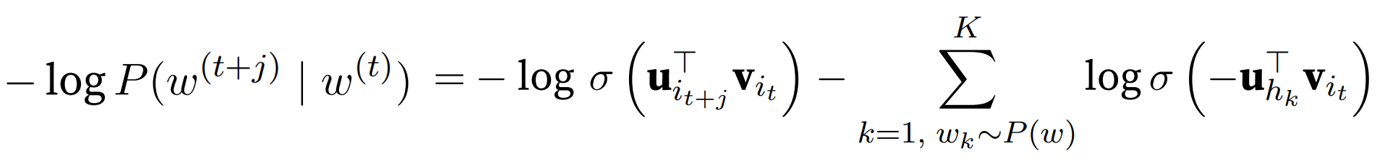

In [ ]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### Initializing Model Parameters

We define two embedding layers
for all the words in the vocabulary
when they are used as center words
and context words, respectively.
The word vector dimension
`embed_size` is set to 100.


In [ ]:
embed_size = 100
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))

### Defining the Training Loop

The training loop is defined below. Because of the existence of padding, the calculation of the loss function is slightly different compared to the previous training functions.


In [ ]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (
                loss(pred.reshape(label.shape).float(), label.float(), mask) /
                mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

Now we can train a skip-gram model using negative sampling.


loss 0.410, 154672.2 tokens/sec on cuda:0


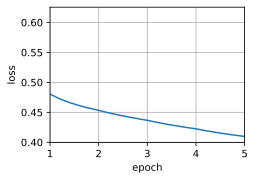

In [ ]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## Applying Word Embeddings

After training the word2vec model,
we can use the cosine similarity
of word vectors from the trained model
to 
find words from the dictionary
that are most semantically similar
to an input word.

Note: we typically take the "center words" embedding (i.e., net[0] in this example). 

In [ ]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(
        W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k + 1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.729: intel
cosine sim=0.686: microprocessor
cosine sim=0.649: bugs
